In [ ]:
# a reasonable alternative to BioconductR may be ggraph
# (for visualization and / or for analyses)

In [1]:
R.version.string

[1] "R version 3.6.1 (2019-07-05)"

### Alternative network library - ggraph and tidygraph

In [2]:
#as suggested by https://www.jessesadler.com/post/network-analysis-with-r/
library(tidyverse)
library(tidygraph)
library(ggraph)
library(tibble)
library(igraph)

# Jupyter R Notebooks can install packages (e.g.):
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")
#BiocManager::install("RBGL")

#install.packages("rbenchmark", repos='http://cran.us.r-project.org')
#install.packages("data.table", repos='http://cran.us.r-project.org')
#install.packages("tidyverse", repos='http://cran.us.r-project.org')


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'tidygraph' was built under R version 3.6.3"
Attaching package: 'tidygraph'

The following object is masked from 'package:stats':

    filter

Warning message:
"package 'ggraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following object is masked from 'package:tidygraph':

    groups

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following objects are masked from 'package:purrr':

    compose, simplify

The following object is masked from 'package:tidyr':

    crossing

The following object is masked from 'package

In [3]:
#connectivity_data
# - table of barrier-to-barrier connectivity by barrier ID
connectivity_data<-read_csv("FIPEX_connectivity.csv")
connectivity_data

Parsed with column specification:
cols(
  ObID = col_double(),
  BarrierOrFlagID = col_double(),
  Downstream_Barrier = col_character(),
  BarrierOrFlagLabel = col_character(),
  Downstream_BarrierLabel = col_character()
)


ObID,BarrierOrFlagID,Downstream_Barrier,BarrierOrFlagLabel,Downstream_BarrierLabel
<dbl>,<dbl>,<chr>,<chr>,<chr>
1,83,Sink,6,Sink
2,84,83,D,6
3,96,83,7,6
4,98,84,E,D
5,94,96,A,7
6,97,96,B,7
7,99,98,F,E
8,95,94,2,A
9,100,97,C,B


In [4]:
barrier_info<-read_csv("FIPEX_BarrierHabitatLine.csv")
barrier_info

Parsed with column specification:
cols(
  ObID = col_double(),
  BarrierID = col_character(),
  Quantity = col_double(),
  BarrierPerm = col_double(),
  NaturalYN = col_logical()
)


ObID,BarrierID,Quantity,BarrierPerm,NaturalYN
<dbl>,<chr>,<dbl>,<dbl>,<lgl>
1,Sink,568.73,0,FALSE
2,83,1777.89,1,FALSE
3,84,670.25,0,FALSE
4,96,1938.39,1,FALSE
5,98,698.75,0,FALSE
6,94,856.91,0,FALSE
7,97,1585.28,0,FALSE
8,99,4455.92,0,FALSE
9,95,0.00,1,FALSE


In [5]:
#nodes
nodes <- barrier_info %>% 
# distinct just in case
distinct(BarrierID)%>%
rowid_to_column("id") %>%
rename(label = BarrierID) %>%
select(id, label)

nodes

id,label
<int>,<chr>
1,Sink
2,83
3,84
4,96
5,98
6,94
7,97
8,99
9,95


In [6]:
#edges
edges <- connectivity_data %>%
left_join(nodes, by = c("Downstream_Barrier" = "label")) %>%
rename(from = id) %>%
mutate(BarrierOrFlagID = as.character(BarrierOrFlagID)) %>%
left_join(nodes, by = c("BarrierOrFlagID" = "label")) %>%
rename(to = id) %>%
left_join(barrier_info, by = c("Downstream_Barrier" = "BarrierID")) %>%
rename(weight = Quantity) %>%
#mutate(weight = 1) %>% 
select(from,to,weight)

edges

from,to,weight
<int>,<int>,<dbl>
1,2,568.73
2,3,1777.89
2,4,1777.89
3,5,670.25
4,6,1938.39
4,7,1938.39
5,8,698.75
6,9,856.91
7,10,1585.28


In [7]:
# this should report it is a 'rooted tree'
graph_tidy <- tbl_graph(nodes = nodes, edges = edges, directed = TRUE)
graph_tidy

# A tbl_graph: 12 nodes and 11 edges
#
# A rooted tree
#
# Node Data: 12 x 2 (active)
     id label
  <int> <chr>
1     1 Sink 
2     2 83   
3     3 84   
4     4 96   
5     5 98   
6     6 94   
# ... with 6 more rows
#
# Edge Data: 11 x 3
   from    to weight
  <int> <int>  <dbl>
1     1     2   569.
2     2     3  1778.
3     2     4  1778.
# ... with 8 more rows

Using `tree` as default layout


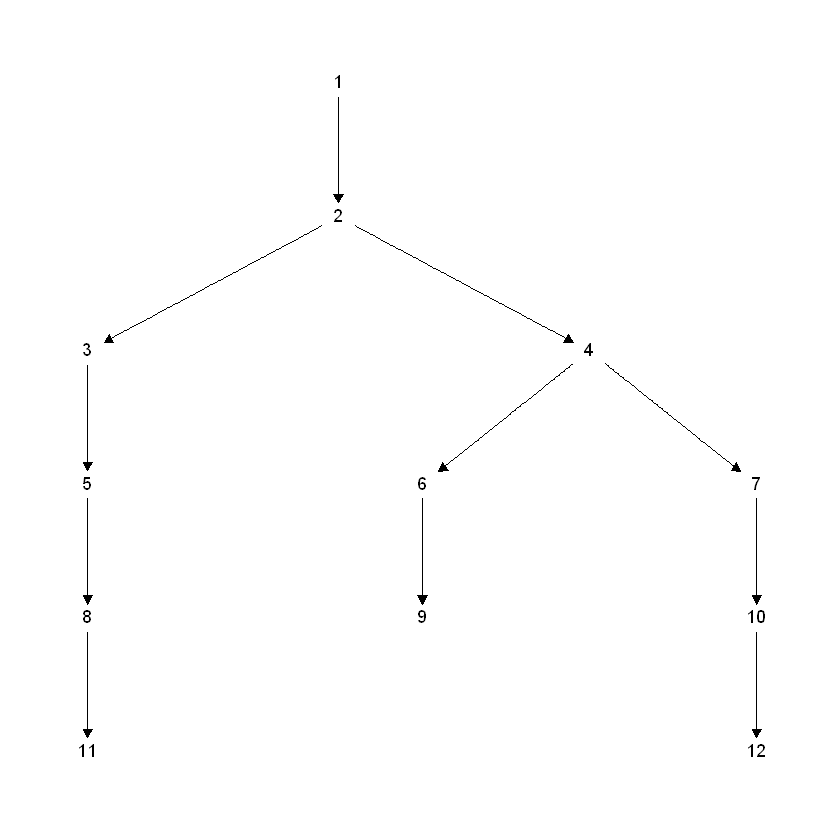

In [8]:
# ggraph inherits syntax of ggplot2
ggraph(graph_tidy) + 
#geom_node_point(fill = NA,
                #alpha = 0.5,
                #size = 2,
                #shape = 1,
                #stroke = 1,
                #fill = "red",
#                colour = "black") + 
geom_edge_link(aes(start_cap = label_rect(node1.label),
                       end_cap = label_rect(node2.label)),
               arrow = arrow(length = unit(0.2, "cm"),
                            type="closed")) + 
geom_node_text(aes(label = id), 
               repel = FALSE) +
theme_graph()

# https://www.data-imaginist.com/2017/ggraph-introduction-nodes/
# https://www.data-imaginist.com/2017/ggraph-introduction-edges/
#https://ggplot2.tidyverse.org/reference/aes_colour_fill_alpha.html

In [9]:
### Find Shortest paths
graph_tidy

# A tbl_graph: 12 nodes and 11 edges
#
# A rooted tree
#
# Node Data: 12 x 2 (active)
     id label
  <int> <chr>
1     1 Sink 
2     2 83   
3     3 84   
4     4 96   
5     5 98   
6     6 94   
# ... with 6 more rows
#
# Edge Data: 11 x 3
   from    to weight
  <int> <int>  <dbl>
1     1     2   569.
2     2     3  1778.
3     2     4  1778.
# ... with 8 more rows

In [10]:
allshortestpaths <- all_shortest_paths(graph_tidy,
                                       1,
                                       to = V(graph_tidy),
                                       mode = c("out", "all", "in"),
                                       weights = NULL)
# see https://igraph.org/r/doc/distances.html

t <- allshortestpaths$res[2]
typeof(t)
s<-t[[1]]
typeof(s)
u<-as.integer(s)
u[1]

[1] "list"

[1] "integer"

[1] 1

In [ ]:
# code below not working to generate an interactive version
# issues is probably just the Jupyter notebook format...
library(visNetwork)
library(networkD3)
library(htmlwidgets)
library(plotly)
#install.packages("visNetwork")
#install.packages("htmlwidgets")

In [ ]:
#not working in notebook
v<-visNetwork(nodes, edges)

In [ ]:
embed_notebook()